In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


In [2]:
import random
import pandas as pd
from faker import Faker

# Load your real dataset containing tweets (replace 'real_dataset.csv' with your file)
real_df = pd.read_csv('train.csv')

# Initialize Faker
fake = Faker()

# Function to generate synthetic data similar to real dataset
def generate_synthetic_data(num_samples):
    synthetic_data = []
    num_real_tweets = len(real_df)
    for _ in range(num_samples):
        # Select a random tweet from the real dataset
        real_tweet = real_df['tweet'].iloc[random.randint(0, num_real_tweets - 1)]
        # Generate fake counts
        count = random.randint(1, 10)
        hate_speech_count = random.randint(0, count)
        offensive_language_count = random.randint(0, count - hate_speech_count)
        neither_count = count - hate_speech_count - offensive_language_count
        # Generate fake class based on counts
        if hate_speech_count > 0:
            label = 0  # Hate speech
        elif offensive_language_count > 0:
            label = 1  # Offensive language
        else:
            label = 2  # Neither
        # Append to synthetic data list
        synthetic_data.append((count, hate_speech_count, offensive_language_count, neither_count, label, real_tweet))
    return synthetic_data

# Generate synthetic data
num_samples = 25000  # Increase the number of samples
synthetic_data = generate_synthetic_data(num_samples)

# Convert synthetic data to DataFrame
columns = ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet']
df = pd.DataFrame(synthetic_data, columns=columns)


In [3]:
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,10,1,6,3,0,Hate on what bitch http://t.co/QzTnw6cdKi
1,5,2,2,1,0,@1SonofYahweh and he whips mommy with the belt...
2,2,2,0,0,0,Been a while since it's just been me solo at t...
3,8,0,5,3,1,RT @PlainBlack_D: Get these trash ass niggas o...
4,6,3,3,0,0,"RT @MichaelJDelaney: @0beyYourMaster real ""lil..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     25000 non-null  int64 
 1   hate_speech_count         25000 non-null  int64 
 2   offensive_language_count  25000 non-null  int64 
 3   neither_count             25000 non-null  int64 
 4   class                     25000 non-null  int64 
 5   tweet                     25000 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [5]:
df.describe()

,count,hate_speech_count,offensive_language_count,neither_count,class
count,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000
mean,5.48632,2.758760,1.364200,1.363360,0.259520
std,2.87147,2.495134,1.773021,1.755156,0.552831
min,1.00000,0.000000,0.000000,0.000000,0.000000
25%,3.00000,1.000000,0.000000,0.000000,0.000000
50%,5.00000,2.000000,1.000000,1.000000,0.000000
75%,8.00000,4.000000,2.000000,2.000000,0.000000
max,10.00000,10.000000,10.000000,10.000000,2.000000


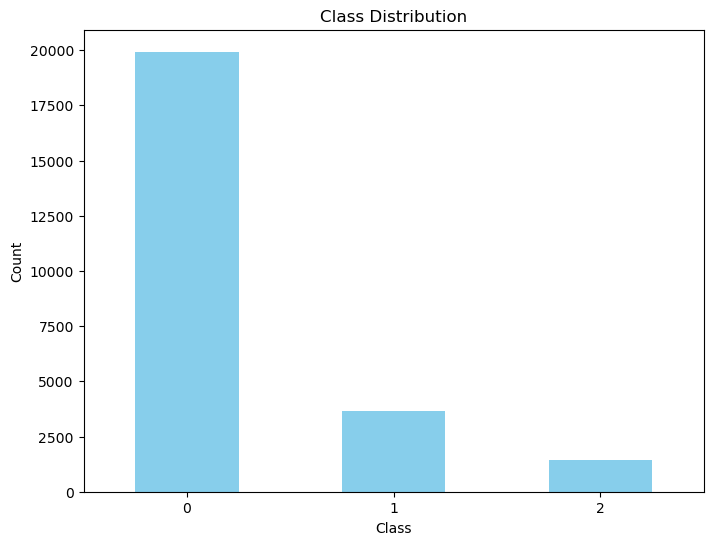

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
df['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


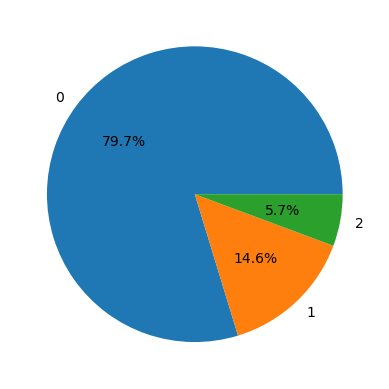

In [7]:
import matplotlib.pyplot as plt
plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


In [8]:
# Balancing the dataset
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1]
class_0 = df[df['class'] == 0].sample(n=8000)

In [9]:
balanced_df = pd.concat([class_2, class_2, class_2, class_2, class_2, class_2, class_2, class_2,  class_2, class_2, 
                         class_1, class_1, class_1, class_1, class_0, class_0], axis=0)

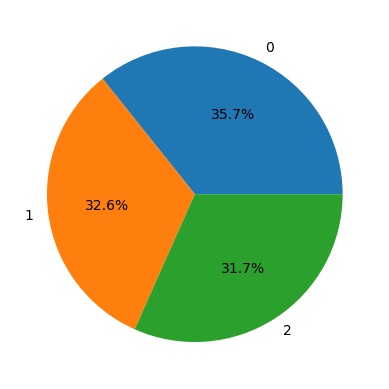

In [10]:
plt.pie(balanced_df['class'].value_counts().values,
		labels=balanced_df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


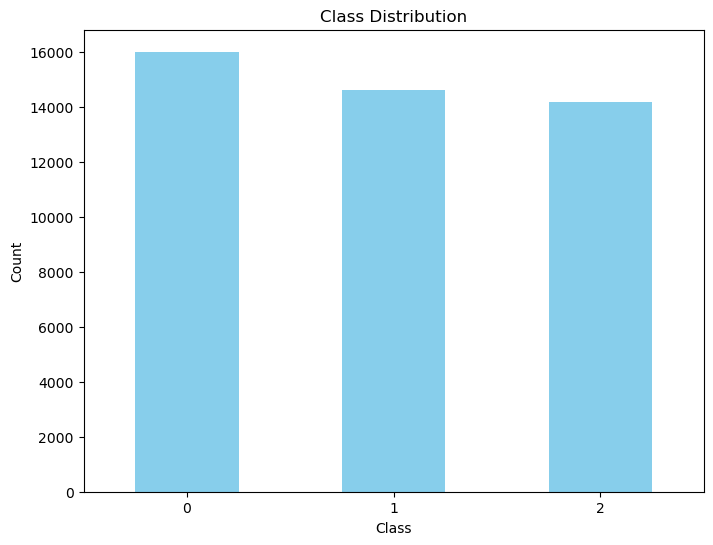

In [11]:
plt.figure(figsize=(8, 6))
balanced_df['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [12]:
balanced_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
9,3,0,0,3,2,Niggas be impregnating the most basic of bitch...
16,8,0,0,8,2,This work shit for the birds....ion think it t...
35,1,0,0,1,2,Madea and this old hillbilly are hilarious tog...
46,5,0,0,5,2,@jessicacassell1 find a new hillbilly!! #spiri...
58,1,0,0,1,2,RT @ChadJordan23: After a hoe gave you head an...


In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
lemmatizer = WordNetLemmatizer()
def preprocess_tweet(text):
    cleaned_text = re.sub(r'@[A-Za-z0-9_]+|https?://[A-Za-z0-9./]+|[^a-zA-Z]', ' ', text)
    cleaned_text = cleaned_text.lower()
    tokens = word_tokenize(cleaned_text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

In [14]:
balanced_df['processed_tweet'] = balanced_df['tweet'].apply(preprocess_tweet)

In [15]:
balanced_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,processed_tweet
9,3,0,0,3,2,Niggas be impregnating the most basic of bitch...,nigga impregnating basic bitch job know drive ...
16,8,0,0,8,2,This work shit for the birds....ion think it t...,work shit bird ion think take hour nothing
35,1,0,0,1,2,Madea and this old hillbilly are hilarious tog...,madea old hillbilly hilarious together
46,5,0,0,5,2,@jessicacassell1 find a new hillbilly!! #spiri...,find new hillbilly spiritweek
58,1,0,0,1,2,RT @ChadJordan23: After a hoe gave you head an...,rt hoe gave head say turn


In [16]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(balanced_df['processed_tweet']).toarray()
y = balanced_df['class']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=101)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
# Machine Learning Algorithms
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB()
}

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      4783
           1       0.61      0.55      0.58      4323
           2       0.74      0.84      0.78      4331

    accuracy                           0.65     13437
   macro avg       0.65      0.65      0.65     13437
weighted avg       0.65      0.65      0.65     13437



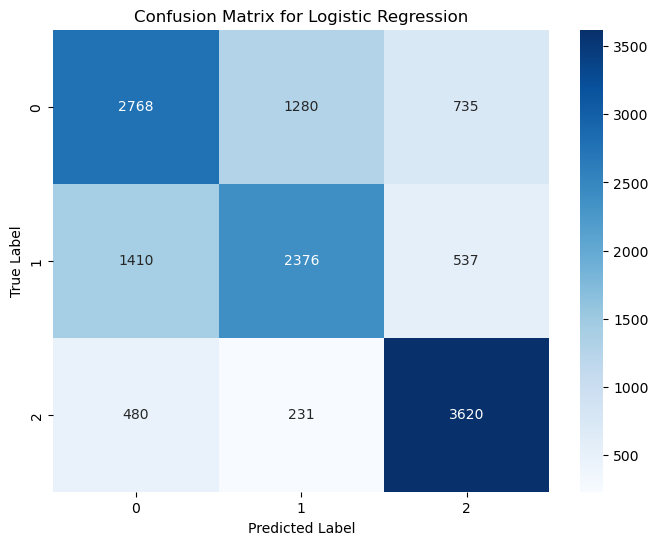

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      4783
           1       0.85      0.85      0.85      4323
           2       0.89      0.99      0.93      4331

    accuracy                           0.87     13437
   macro avg       0.87      0.88      0.87     13437
weighted avg       0.87      0.87      0.87     13437



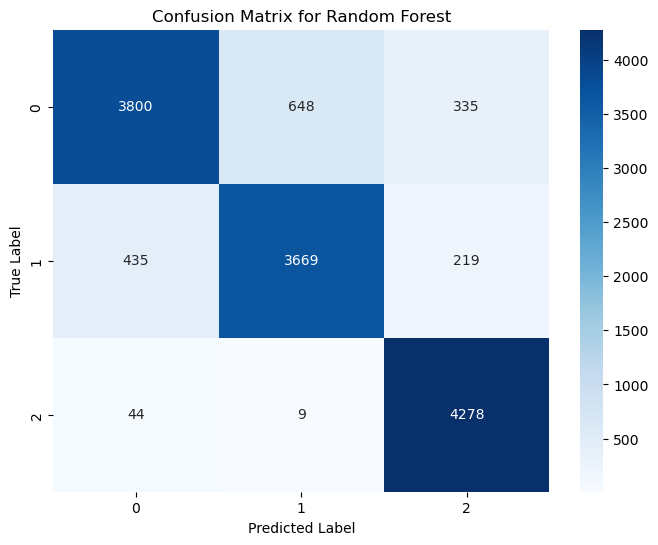

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Classification Report for Multinomial Naive Bayes:")
print(classification_report(y_test, y_pred_nb))


Classification Report for Multinomial Naive Bayes:
              precision    recall  f1-score   support

           0       0.53      0.66      0.58      4783
           1       0.60      0.48      0.53      4323
           2       0.75      0.69      0.72      4331

    accuracy                           0.61     13437
   macro avg       0.62      0.61      0.61     13437
weighted avg       0.62      0.61      0.61     13437



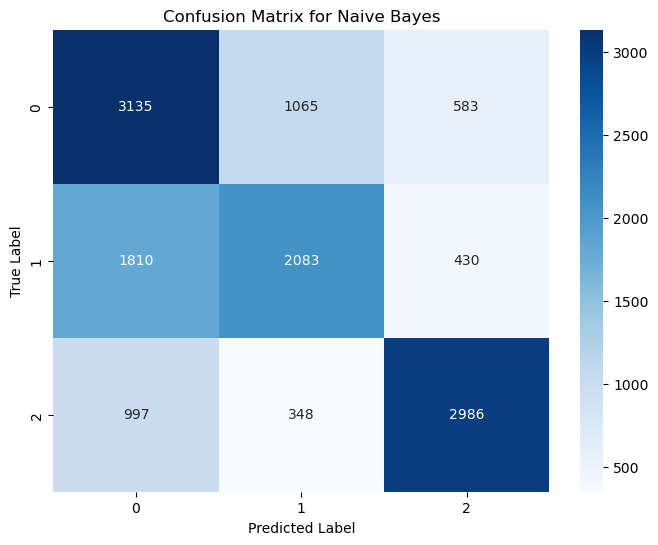

In [24]:
# Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

In [25]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
# Bagging Classifier
bagging = BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10, random_state=42)
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)


In [26]:
# Classification report for Bagging Classifier
print("Classification Report for Bagging Classifier:")
print(classification_report(y_test, y_pred_bagging))

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4783
           1       0.84      0.84      0.84      4323
           2       0.89      0.99      0.93      4331

    accuracy                           0.87     13437
   macro avg       0.87      0.87      0.87     13437
weighted avg       0.87      0.87      0.87     13437



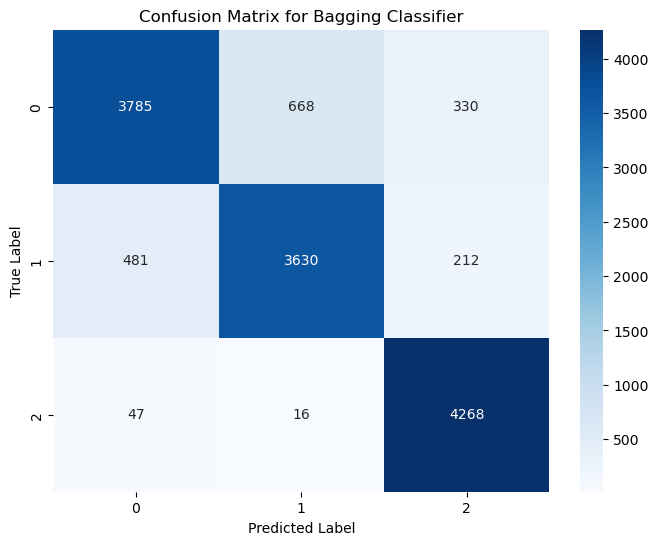

In [27]:
# Confusion Matrix for Bagging Classifier
cm_bagging = confusion_matrix(y_test, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Bagging Classifier')
plt.show()

In [28]:
# AdaBoost Classifier
adaboost = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=10, random_state=42)
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)

In [29]:
# Classification report for AdaBoost Classifier
print("Classification Report for AdaBoost Classifier:")
print(classification_report(y_test, y_pred_adaboost))

Classification Report for AdaBoost Classifier:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4783
           1       0.87      0.80      0.83      4323
           2       0.89      0.98      0.93      4331

    accuracy                           0.87     13437
   macro avg       0.87      0.87      0.87     13437
weighted avg       0.87      0.87      0.87     13437



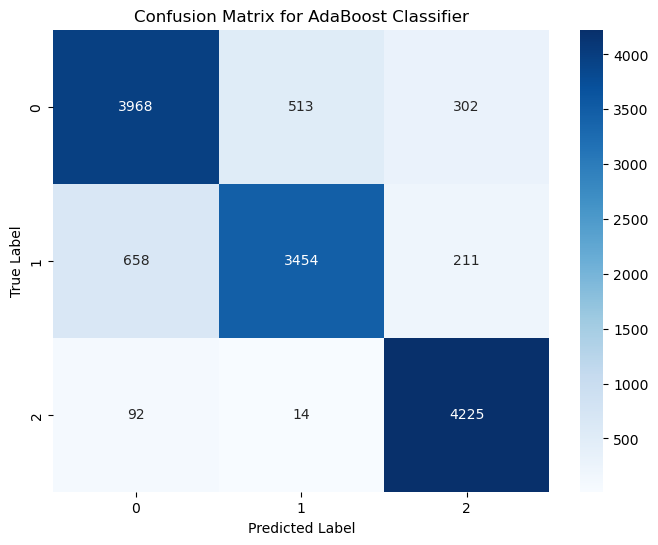

In [31]:
# Confusion Matrix for AdaBoost Classifier
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adaboost, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for AdaBoost Classifier')
plt.show()

In [35]:
# Voting Classifier
voting = VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier()),  ('nb', MultinomialNB())], voting='soft')
voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)

C:\Users\Ananya Gupta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
# Classification report for Voting Classifier
print("Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting))

Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      4756
           1       0.80      0.79      0.79      4449
           2       0.88      0.95      0.92      4262

    accuracy                           0.84     13467
   macro avg       0.83      0.84      0.84     13467
weighted avg       0.83      0.84      0.83     13467



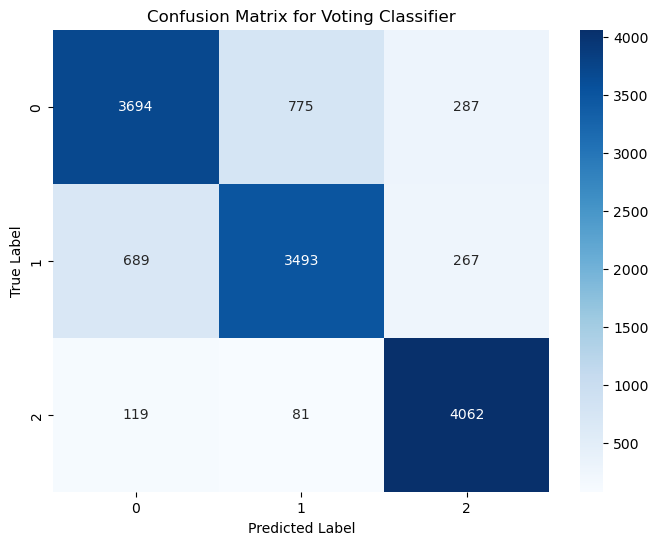

In [37]:
# Confusion Matrix for Voting Classifier
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_voting, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Voting Classifier')
plt.show()


# DEEP LEARNING

In [32]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
# Splitting the dataset
X = balanced_df['processed_tweet']
y = balanced_df['class']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=102)

In [34]:
# One-hot encoding
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [35]:
# Tokenizer
max_words = 15000
max_len = 600

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

In [36]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping with patience and monitoring validation loss
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)



In [37]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define ANN model
ann_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 output classes
])


In [38]:
ann_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
print(ann_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 128)          1920000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1973763 (7.53 MB)
Trainable params: 1973763 (7.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [40]:
from sklearn.metrics import confusion_matrix, classification_report

# Train ANN model
ann_history = ann_model.fit(X_train_pad, y_train_encoded, validation_data=(X_val_pad, y_val_encoded),
                            epochs=15, batch_size=62, callbacks=[es, lr_reduction], verbose=1)


Epoch 1/15


506/506 [==============================] - 135s 262ms/step - loss: 0.9372 - accuracy: 0.5156 - val_loss: 0.7213 - val_accuracy: 0.6693 - lr: 0.0010
Epoch 2/15
506/506 [==============================] - 128s 252ms/step - loss: 0.5998 - accuracy: 0.7480 - val_loss: 0.5610 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 3/15
506/506 [==============================] - 123s 243ms/step - loss: 0.4587 - accuracy: 0.8085 - val_loss: 0.4905 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 4/15
506/506 [==============================] - 125s 247ms/step - loss: 0.3842 - accuracy: 0.8357 - val_loss: 0.4545 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 5/15
506/506 [==============================] - 127s 251ms/step - loss: 0.3385 - accuracy: 0.8519 - val_loss: 0.4384 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 6/15
506/506 [==============================] - 134s 264ms/step - loss: 0.3144 - accuracy: 0.8587 - val_loss: 0.4486 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 7/15
506/506 [========================

In [41]:
# Predict probabilities for each class
y_pred_proba_ann = ann_model.predict(X_val_pad)

# Derive predicted classes
y_pred_ann = np.argmax(y_pred_proba_ann, axis=1)

# Predictions
#y_pred_ann = ann_model.predict_classes(X_val_pad)

# Confusion Matrix
conf_matrix_ann = confusion_matrix(y_val_encoded, y_pred_ann)

420/420 [==============================] - 21s 49ms/step


In [42]:
# Classification Report
class_report_ann = classification_report(y_val_encoded, y_pred_ann)

print("Confusion Matrix for ANN Model:")
print(conf_matrix_ann)
print("\nClassification Report for ANN Model:")
print(class_report_ann)


Confusion Matrix for ANN Model:
[[3154 1088  465]
 [ 419 3721  271]
 [  82   54 4183]]

Classification Report for ANN Model:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      4707
           1       0.77      0.84      0.80      4411
           2       0.85      0.97      0.91      4319

    accuracy                           0.82     13437
   macro avg       0.83      0.83      0.82     13437
weighted avg       0.83      0.82      0.82     13437



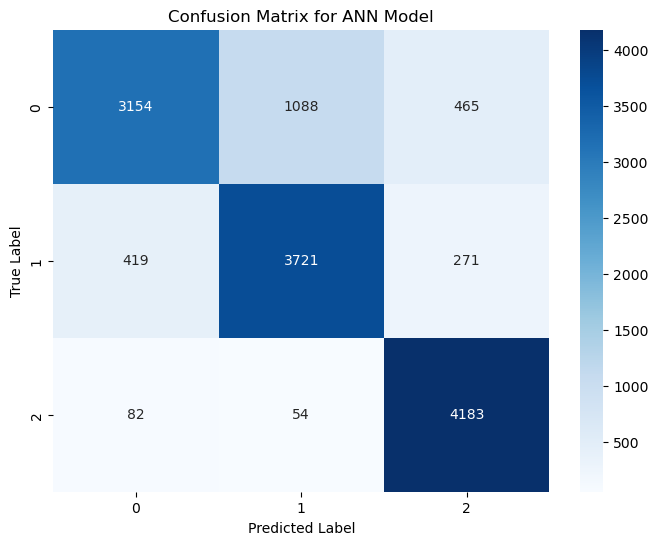

In [43]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ann, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ANN Model')
plt.show()

In [44]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define CNN model
cnn_model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Assuming 3 output classes
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [45]:

# Train CNN model
cnn_history = cnn_model.fit(X_train_pad, y_train_encoded, validation_data=(X_val_pad, y_val_encoded),
                            epochs=20, batch_size=64, callbacks=[es, lr_reduction], verbose=1)


Epoch 1/20
490/490 [==============================] - 15s 27ms/step - loss: 0.9170 - accuracy: 0.5109 - val_loss: 0.6688 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 2/20
490/490 [==============================] - 10s 21ms/step - loss: 0.5529 - accuracy: 0.7672 - val_loss: 0.4958 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 3/20
490/490 [==============================] - 10s 20ms/step - loss: 0.3963 - accuracy: 0.8486 - val_loss: 0.4063 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 4/20
490/490 [==============================] - 10s 20ms/step - loss: 0.3338 - accuracy: 0.8691 - val_loss: 0.3794 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 5/20
490/490 [==============================] - 10s 21ms/step - loss: 0.2959 - accuracy: 0.8810 - val_loss: 0.3534 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 6/20
490/490 [==============================] - 11s 22ms/step - loss: 0.2734 - accuracy: 0.8863 - val_loss: 0.3387 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 7/20
490/490 [==============================] - 10s 

In [46]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 32)           480000    
                                                                 
 conv1d (Conv1D)             (None, 596, 32)           5152      
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 32)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4768)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               610432    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [47]:
# Predict probabilities for each class
y_pred_proba_cnn = cnn_model.predict(X_val_pad)

# Derive predicted classes
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Predictions
#y_pred_ann = ann_model.predict_classes(X_val_pad)

# Confusion Matrix
conf_matrix_cnn = confusion_matrix(y_val_encoded, y_pred_cnn)

420/420 [==============================] - 1s 2ms/step


In [48]:
# Classification Report
class_report_cnn = classification_report(y_val_encoded, y_pred_cnn)

print("Confusion Matrix for CNN Model:")
print(conf_matrix_ann)
print("\nClassification Report for CNN Model:")
print(class_report_cnn)


Confusion Matrix for CNN Model:
[[3154 1088  465]
 [ 419 3721  271]
 [  82   54 4183]]

Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.92      0.73      0.82      4707
           1       0.81      0.89      0.85      4411
           2       0.89      0.99      0.93      4319

    accuracy                           0.87     13437
   macro avg       0.87      0.87      0.87     13437
weighted avg       0.87      0.87      0.87     13437



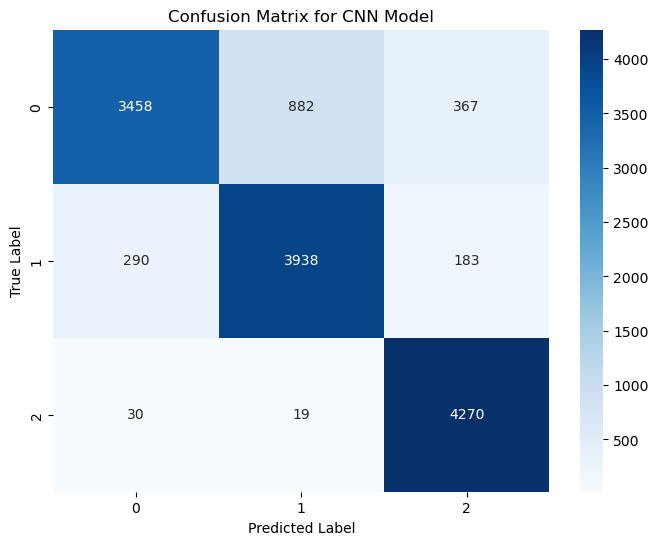

In [49]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Model')
plt.show()

In [50]:
from keras.layers import LSTM
# Define LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Assuming 3 output classes
])

In [51]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [52]:
# Train LSTM model
lstm_history = lstm_model.fit(X_train_pad, y_train_encoded, validation_data=(X_val_pad, y_val_encoded),
                              epochs=15, batch_size=62, callbacks=[es, lr_reduction], verbose=1)


Epoch 1/15
506/506 [==============================] - 115s 221ms/step - loss: 0.8981 - accuracy: 0.5446 - val_loss: 0.7053 - val_accuracy: 0.6759 - lr: 0.0010
Epoch 2/15
506/506 [==============================] - 105s 207ms/step - loss: 0.5639 - accuracy: 0.7599 - val_loss: 0.5526 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 3/15
506/506 [==============================] - 106s 210ms/step - loss: 0.4356 - accuracy: 0.8139 - val_loss: 0.4806 - val_accuracy: 0.7971 - lr: 0.0010
Epoch 4/15
506/506 [==============================] - 107s 212ms/step - loss: 0.3679 - accuracy: 0.8412 - val_loss: 0.4675 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 5/15
506/506 [==============================] - 111s 219ms/step - loss: 0.3278 - accuracy: 0.8549 - val_loss: 0.4393 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 6/15
506/506 [==============================] - 105s 208ms/step - loss: 0.3008 - accuracy: 0.8621 - val_loss: 0.4392 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 7/15
506/506 [==========================

In [53]:
# Predict probabilities for each class
y_pred_proba_lstm = lstm_model.predict(X_val_pad)

# Derive predicted classes
y_pred_lstm = np.argmax(y_pred_proba_lstm, axis=1)

# Predictions
#y_pred_ann = ann_model.predict_classes(X_val_pad)

# Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_val_encoded, y_pred_lstm)

420/420 [==============================] - 17s 39ms/step


In [54]:
class_report_lstm = classification_report(y_val_encoded, y_pred_lstm)
print("Confusion Matrix for LSTM Model:")
print(conf_matrix_lstm)
print("\nClassification Report for LSTM Model:")
print(class_report_lstm)

Confusion Matrix for LSTM Model:
[[3072 1096  539]
 [ 304 3766  341]
 [   6   16 4297]]

Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      4707
           1       0.77      0.85      0.81      4411
           2       0.83      0.99      0.91      4319

    accuracy                           0.83     13437
   macro avg       0.84      0.83      0.83     13437
weighted avg       0.84      0.83      0.82     13437



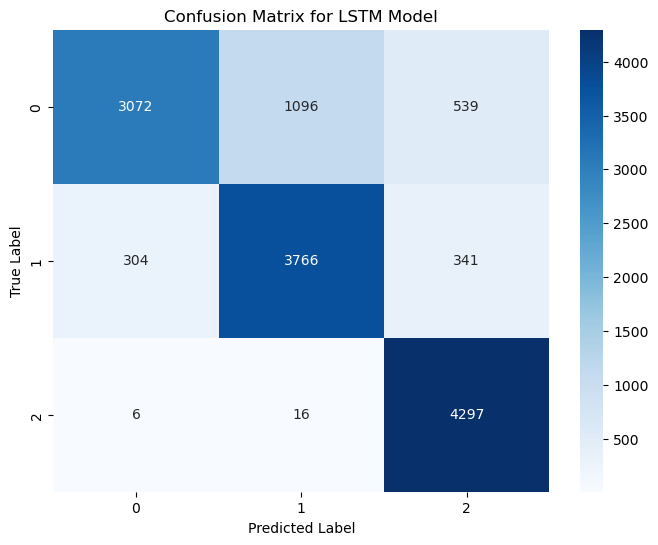

In [55]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [56]:
from keras.layers import Bidirectional

# Define BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Assuming 3 output classes
])


In [57]:
bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [58]:
# Train BiLSTM model
bilstm_history = bilstm_model.fit(X_train_pad, y_train_encoded, validation_data=(X_val_pad, y_val_encoded),
                                  epochs=15, batch_size=62, callbacks=[es, lr_reduction], verbose=1)


Epoch 1/15
506/506 [==============================] - 207s 401ms/step - loss: 0.9000 - accuracy: 0.5504 - val_loss: 0.6880 - val_accuracy: 0.6911 - lr: 0.0010
Epoch 2/15
506/506 [==============================] - 215s 426ms/step - loss: 0.5451 - accuracy: 0.7719 - val_loss: 0.5332 - val_accuracy: 0.7736 - lr: 0.0010
Epoch 3/15
506/506 [==============================] - 216s 428ms/step - loss: 0.4290 - accuracy: 0.8189 - val_loss: 0.4896 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 4/15
506/506 [==============================] - 216s 426ms/step - loss: 0.3691 - accuracy: 0.8395 - val_loss: 0.4432 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 5/15
506/506 [==============================] - 208s 411ms/step - loss: 0.3274 - accuracy: 0.8532 - val_loss: 0.4346 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 6/15
506/506 [==============================] - 202s 399ms/step - loss: 0.3027 - accuracy: 0.8612 - val_loss: 0.4262 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 7/15
506/506 [==========================

In [59]:
# Predict probabilities for each class
y_pred_proba_bilstm = bilstm_model.predict(X_val_pad)

# Derive predicted classes
y_pred_bilstm = np.argmax(y_pred_proba_bilstm, axis=1)

# Predictions
#y_pred_ann = ann_model.predict_classes(X_val_pad)

# Confusion Matrix
conf_matrix_bilstm = confusion_matrix(y_val_encoded, y_pred_bilstm)

420/420 [==============================] - 25s 58ms/step


In [60]:
class_report_bilstm = classification_report(y_val_encoded, y_pred_bilstm)
print("Confusion Matrix for BILSTM Model:")
print(conf_matrix_bilstm)
print("\nClassification Report for BILSTM Model:")
print(class_report_bilstm)

Confusion Matrix for BILSTM Model:
[[3070 1172  465]
 [ 296 3828  287]
 [  43   53 4223]]

Classification Report for BILSTM Model:
              precision    recall  f1-score   support

           0       0.90      0.65      0.76      4707
           1       0.76      0.87      0.81      4411
           2       0.85      0.98      0.91      4319

    accuracy                           0.83     13437
   macro avg       0.84      0.83      0.82     13437
weighted avg       0.84      0.83      0.82     13437



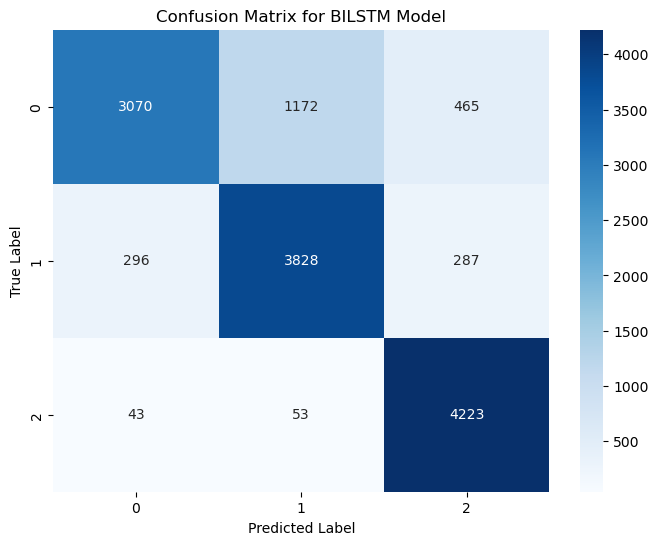

In [61]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bilstm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BILSTM Model')
plt.show()

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

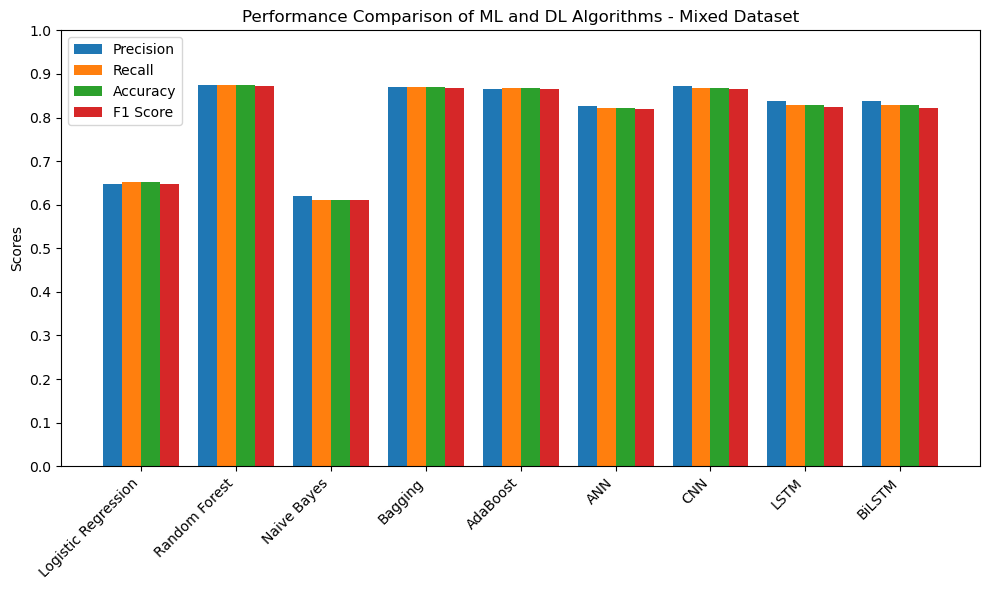

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Define evaluation metrics
metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']

# Define models and their corresponding scores
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Bagging', 'AdaBoost', 'ANN', 'CNN', 'LSTM', 'BiLSTM']
precision_scores = [precision_score(y_test, y_pred_lr, average='weighted'),
                    precision_score(y_test, y_pred_rf, average='weighted'),
                    
                    precision_score(y_test, y_pred_nb, average='weighted'),
                    precision_score(y_test, y_pred_bagging, average='weighted'),
                    precision_score(y_test, y_pred_adaboost, average='weighted'),
                    precision_score(y_val_encoded, y_pred_ann, average='weighted'),
                    precision_score(y_val_encoded, y_pred_cnn, average='weighted'),
                    precision_score(y_val_encoded, y_pred_lstm, average='weighted'),
                    precision_score(y_val_encoded, y_pred_bilstm, average='weighted')]
recall_scores = [recall_score(y_test, y_pred_lr, average='weighted'),
                 recall_score(y_test, y_pred_rf, average='weighted'),
                 recall_score(y_test, y_pred_nb, average='weighted'),
                 recall_score(y_test, y_pred_bagging, average='weighted'),
                recall_score(y_test, y_pred_adaboost, average='weighted'),
                 recall_score(y_val_encoded, y_pred_ann, average='weighted'),
                 recall_score(y_val_encoded, y_pred_cnn, average='weighted'),
                 recall_score(y_val_encoded, y_pred_lstm, average='weighted'),
                 recall_score(y_val_encoded, y_pred_bilstm, average='weighted')]
accuracy_scores = [accuracy_score(y_test, y_pred_lr),
                   accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_nb),
                   accuracy_score(y_test, y_pred_bagging),
                   accuracy_score(y_test, y_pred_adaboost),
                   accuracy_score(y_val_encoded, y_pred_ann),
                   accuracy_score(y_val_encoded, y_pred_cnn),
                   accuracy_score(y_val_encoded, y_pred_lstm),
                   accuracy_score(y_val_encoded, y_pred_bilstm)]
f1_scores = [f1_score(y_test, y_pred_lr, average='weighted'),
             f1_score(y_test, y_pred_rf, average='weighted'),
             f1_score(y_test, y_pred_nb, average='weighted'),
             f1_score(y_test, y_pred_bagging, average='weighted'),
             f1_score(y_test, y_pred_adaboost, average='weighted'),
             f1_score(y_val_encoded, y_pred_ann, average='weighted'),
             f1_score(y_val_encoded, y_pred_cnn, average='weighted'),
             f1_score(y_val_encoded, y_pred_lstm, average='weighted'),
             f1_score(y_val_encoded, y_pred_bilstm, average='weighted')]

# Plotting
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, precision_scores, width, label='Precision')
rects2 = ax.bar(x - 0.5*width, recall_scores, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, accuracy_scores, width, label='Accuracy')
rects4 = ax.bar(x + 1.5*width, f1_scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of ML and DL Algorithms - Mixed Dataset')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()


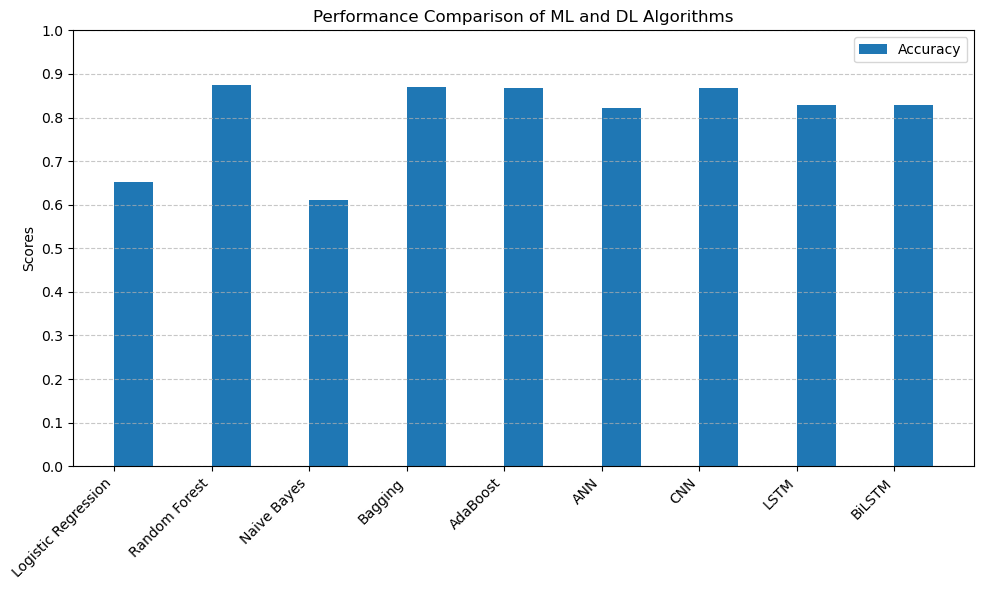

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Define evaluation metrics
metrics = ['Accuracy']

# Define models and their corresponding scores
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Bagging', 'AdaBoost', 'ANN', 'CNN', 'LSTM', 'BiLSTM']

accuracy_scores = [accuracy_score(y_test, y_pred_lr),
                   accuracy_score(y_test, y_pred_rf),
                   accuracy_score(y_test, y_pred_nb),
                   accuracy_score(y_test, y_pred_bagging),
                   accuracy_score(y_test, y_pred_adaboost),
                   accuracy_score(y_val_encoded, y_pred_ann),
                   accuracy_score(y_val_encoded, y_pred_cnn),
                   accuracy_score(y_val_encoded, y_pred_lstm),
                   accuracy_score(y_val_encoded, y_pred_bilstm)]


# Plotting
x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))

rects3 = ax.bar(x + 0.5*width, accuracy_scores, width, label='Accuracy')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of ML and DL Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()


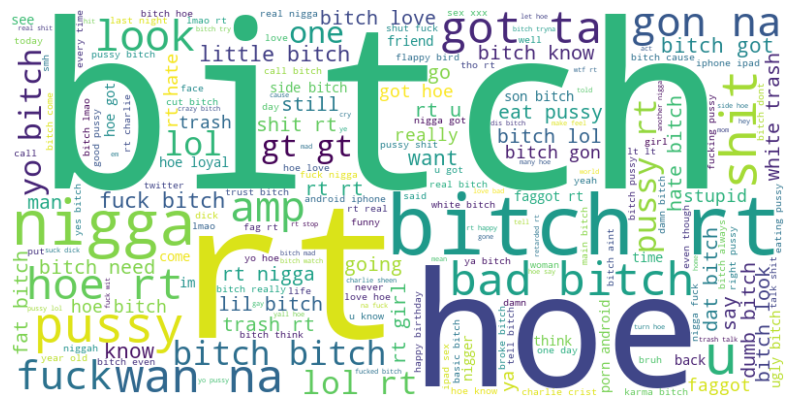

In [66]:
from wordcloud import WordCloud

# Concatenate all tweets into a single string
all_tweets = ' '.join(balanced_df['processed_tweet'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [69]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
lemmatizer = WordNetLemmatizer()

# Function to preprocess the tweet
def preprocess_tweet(text):
    cleaned_text = re.sub(r'@[A-Za-z0-9_]+|https?://[A-Za-z0-9./]+|[^a-zA-Z]', ' ', text)
    cleaned_text = cleaned_text.lower()
    tokens = word_tokenize(cleaned_text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

# Function to predict tweet class using ML and DL models
def predict_tweet_class(tweet):
    processed_tweet = preprocess_tweet(tweet)
    
    # TF-IDF vectorization
    processed_tweet_tfidf = tfidf_vectorizer.transform([processed_tweet]).toarray()
    
    # Tokenization and padding for DL models
    processed_tweet_seq = tokenizer.texts_to_sequences([processed_tweet])
    processed_tweet_pad = pad_sequences(processed_tweet_seq, maxlen=max_len)
    
    # Make predictions using ML models
    ml_predictions = {
        'Logistic Regression': lr.predict(processed_tweet_tfidf)[0],
        'Random Forest': rf.predict(processed_tweet_tfidf)[0],
        'Naive Bayes': nb.predict(processed_tweet_tfidf)[0],
        'Bagging': bagging.predict(processed_tweet_tfidf)[0],
        'AdaBoost': adaboost.predict(processed_tweet_tfidf)[0]
    }
    
    # Make predictions using DL models
    dl_predictions = {
        'LSTM': np.argmax(lstm_model.predict(processed_tweet_pad), axis=1)[0],
        'ANN': np.argmax(ann_model.predict(processed_tweet_pad), axis=1)[0],
        'CNN': np.argmax(cnn_model.predict(processed_tweet_pad), axis=1)[0],
        'BiLSTM': np.argmax(bilstm_model.predict(processed_tweet_pad), axis=1)[0]
    }
    
    # Combine predictions from all models
    all_predictions = list(ml_predictions.values()) + list(dl_predictions.values())
    
    # Determine the final prediction based on majority voting
    final_prediction = max(Counter(all_predictions), key=Counter(all_predictions).get)
    
    # Check if the predicted class is offensive or hate
    block_user = False
    if final_prediction in [0, 1]:
        block_user = True
        if final_prediction == 0:
            print("User blocked for posting hate content.")
        else:
            print("User blocked for posting offensive content.")


    return {
        'ML Predictions': ml_predictions,
        'DL Predictions': dl_predictions,
        'Final Prediction': final_prediction,
        'Block User': block_user
    }

# Example usage
user_tweet = input("Enter your tweet: ")
prediction_result = predict_tweet_class(user_tweet)
print("ML Predictions:", prediction_result['ML Predictions'])
print("DL Predictions:", prediction_result['DL Predictions'])
print("Final Prediction:", prediction_result['Final Prediction'])
print("Block User:", prediction_result['Block User'])


Enter your tweet: you are not good
1/1 [==============================] - 0s 34ms/step
User blocked for posting hate content.
ML Predictions: {'Logistic Regression': 0, 'Random Forest': 0, 'Naive Bayes': 0, 'Bagging': 0, 'AdaBoost': 0}
DL Predictions: {'LSTM': 1, 'ANN': 1, 'CNN': 0, 'BiLSTM': 1}
Final Prediction: 0
Block User: True
